In [1]:
# ==== Part 3.2: TextCNN for Topic Classification ====
import time, copy, random, math
from collections import Counter, defaultdict
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
import matplotlib.pyplot as plt
from torchtext import data, datasets

In [2]:
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("[Info] Device:", device)

[Info] Device: cpu


In [3]:
# -----------------------
# Config
# -----------------------
CFG = {
    "epochs": 20,
    "batch_size": 64,
    "lr": 1e-3,
    "weight_decay": 1e-5,    # L2 regularization
    "dropout": 0.5,
    "n_filters": 100,        # per kernel size
    "filter_sizes": [3, 4, 5],
    "early_stopping": True,
    "patience": 4,
    "warmup_freeze_emb": 0,  # set >0 to freeze embeddings for first N epochs
}

In [4]:
# ========================================
# LOAD DATASET
# ========================================
print("\n" + "="*60)
print("LOADING TREC DATASET")
print("="*60)

# Define fields
TEXT = data.Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    include_lengths=True,
    lower=True
)

LABEL = data.LabelField()

# Load TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

print(f"\nDataset loaded successfully!")
print(f"Number of training examples: {len(train_data)}")
print(f"Number of test examples: {len(test_data)}")

# Show example
print("\nExample training instance:")
print(f"Text: {' '.join(train_data.examples[0].text)}")
print(f"Label: {train_data.examples[0].label}")


LOADING TREC DATASET

Dataset loaded successfully!
Number of training examples: 5452
Number of test examples: 500

Example training instance:
Text: how did serfdom develop in and then leave russia ?
Label: DESC


In [5]:
# ========================================
# SPLIT TRAIN INTO TRAIN/VALIDATION (80/20)
# ========================================
import random
random.seed(SEED)

train_data, val_data = train_data.split(split_ratio=0.8, random_state=random.seed(SEED))

print(f"\nAfter split:")
print(f"Train set: {len(train_data)} examples")
print(f"Validation set: {len(val_data)} examples")
print(f"Test set: {len(test_data)} examples")


After split:
Train set: 4362 examples
Validation set: 1090 examples
Test set: 500 examples


In [6]:
# -----------------------
# Load saved vocab & enhanced embeddings (from Part 1)
# -----------------------
VOCAB_PATH = "./vocabs_both.pt"          
EMB_PATH   = "./enhanced_embeddings.pt"  

print("[Info] Loading:", VOCAB_PATH, "and", EMB_PATH)
vocabs = torch.load("./vocabs_both.pt", map_location="cpu", weights_only=False)
text_itos = vocabs["text_vocab"]["itos"]
text_stoi = vocabs["text_vocab"]["stoi"]
label_itos = vocabs["label_vocab"]["itos"]
label_stoi = vocabs["label_vocab"]["stoi"]

emb = torch.load(EMB_PATH, map_location="cpu")

[Info] Loading: ./vocabs_both.pt and ./enhanced_embeddings.pt


In [7]:
from torchtext.vocab import Vocab

# (1) Activate TEXT.vocab with your saved mapping
txt_cnt = Counter({tok: 1 for tok in text_itos})
# Preserve specials if your Field uses them
specials = []
for s in [getattr(TEXT, "unk_token", "<unk>"),
          getattr(TEXT, "pad_token", "<pad>"),
          getattr(TEXT, "init_token", None),
          getattr(TEXT, "eos_token", None)]:
    if s and s in text_stoi:
        specials.append(s)

TEXT.vocab = Vocab(txt_cnt, specials=specials)
TEXT.vocab.itos = list(text_itos)
TEXT.vocab.stoi = dict(text_stoi)

In [8]:
TEXT.vocab.vectors = emb.clone()

# (2) Activate LABEL.vocab with your saved mapping
lab_cnt = Counter({tok: 1 for tok in label_itos})
LABEL.vocab = Vocab(lab_cnt, specials=[])  # label field usually has no specials
LABEL.vocab.itos = list(label_itos)
LABEL.vocab.stoi = dict(label_stoi)

# (3) Recompute sizes/indices used by the model
INPUT_DIM = len(TEXT.vocab)
EMBED_DIM = TEXT.vocab.vectors.size(1) # if hasattr(TEXT.vocab, "vectors") else 300
PAD_IDX   = TEXT.vocab.stoi.get(getattr(TEXT, "pad_token", "<pad>"), 1)
UNK_IDX = getattr(TEXT, "unk_token", "<unk>")
base = dict(TEXT.vocab.stoi)
TEXT.vocab.stoi = defaultdict(lambda: base[UNK_IDX], base)
N_CLASSES = len(LABEL.vocab)

print(f"[OK] Activated vocabs | tokens={INPUT_DIM}, labels={N_CLASSES}, emb_dim={EMBED_DIM}")

[OK] Activated vocabs | tokens=7435, labels=6, emb_dim=300


In [9]:
# -----------------------
# Iterators
# -----------------------
BATCH_SIZE = CFG["batch_size"]
train_iter, valid_iter, test_iter = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda ex: len(ex.text),
    device=device
)
print("[OK] Built BucketIterators.")

[OK] Built BucketIterators.


In [10]:
# -----------------------
# Model: TextCNN
# -----------------------
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_classes, pad_idx,
                 n_filters=100, filter_sizes=(3,4,5), dropout=0.5, vectors=None, train_embeddings=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        if vectors is not None:
            self.embedding.weight.data.copy_(vectors)
        self.embedding.weight.requires_grad = train_embeddings

        # NOTE: add padding=fs//2 so kernels fit even on very short sequences
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim,
                      out_channels=n_filters,
                      kernel_size=fs,
                      padding=fs // 2)
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(n_filters * len(filter_sizes), n_classes)

    def forward(self, text, text_lengths=None):
        if isinstance(text, (tuple, list)):  # safety if called with (text, lengths)
            text = text[0]
        embedded = self.embedding(text)        # [seq_len, batch, emb]
        embedded = embedded.permute(1, 2, 0)   # [batch, emb, seq_len]
        conved  = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled  = [torch.max(c, dim=2).values for c in conved]  # global max over time
        cat     = torch.cat(pooled, dim=1)
        return self.fc(self.dropout(cat))

In [11]:
# Instantiate
N_CLASSES = len(LABEL.vocab)
vectors = TEXT.vocab.vectors.to(device)
model = TextCNN(
    vocab_size=INPUT_DIM,
    embed_dim=EMBED_DIM,
    n_classes=N_CLASSES,
    pad_idx=PAD_IDX,
    n_filters=CFG["n_filters"],
    filter_sizes=tuple(CFG["filter_sizes"]),
    dropout=CFG["dropout"],
    vectors=vectors,
    train_embeddings=True
).to(device)

print(model)

# Keep PAD row zero (stability)
with torch.no_grad():
    model.embedding.weight[PAD_IDX].fill_(0.0)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])

TextCNN(
  (embedding): Embedding(7435, 300, padding_idx=1)
  (convs): ModuleList(
    (0): Conv1d(300, 100, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(300, 100, kernel_size=(4,), stride=(1,), padding=(2,))
    (2): Conv1d(300, 100, kernel_size=(5,), stride=(1,), padding=(2,))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=6, bias=True)
)


In [12]:
# -----------------------
# Training / evaluation
# -----------------------
def categorical_accuracy(logits, y):
    preds = logits.argmax(1)
    return (preds == y).float().mean().item()

def run_epoch(model, iterator, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    tot_loss, tot_acc, n_batches = 0.0, 0.0, 0
    for batch in iterator:
        # torchtext legacy: batch.text is (text, lengths) if include_lengths=True
        if isinstance(batch.text, tuple) or isinstance(batch.text, list):
            text, text_lengths = batch.text
        else:
            text, text_lengths = batch.text, None
        y = batch.label

        if is_train:
            optimizer.zero_grad()
        logits = model(text, text_lengths)
        loss = criterion(logits, y)
        acc = categorical_accuracy(logits, y)

        if is_train:
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()

        tot_loss += loss.item(); tot_acc += acc; n_batches += 1

    return tot_loss / max(n_batches,1), tot_acc / max(n_batches,1)

history = {"train_loss": [], "valid_acc": []}
best_state = None
best_val_acc = -1.0
epochs_no_improve = 0

# Optional warmup freeze
if CFG["warmup_freeze_emb"] > 0:
    for p in model.embedding.parameters():
        p.requires_grad = False
    print(f"[Info] Freezing embeddings for the first {CFG['warmup_freeze_emb']} epoch(s).")

import json
LAST_PATH = "./models/cnn_textclf_last.pt"
BEST_PATH = "./models/cnn_textclf_best.pt"
META_PATH = "./models/cnn_textclf_meta.json"
LABEL_PATH = "./models/label_vocab.pt"

for epoch in range(1, CFG["epochs"] + 1):
    start = time.time()

    # Unfreeze after warmup
    if CFG["warmup_freeze_emb"] > 0 and epoch == CFG["warmup_freeze_emb"] + 1:
        for p in model.embedding.parameters():
            p.requires_grad = True
        print("[Info] Unfroze embeddings.")

    tr_loss, tr_acc = run_epoch(model, train_iter, optimizer=optimizer)
    va_loss, va_acc = run_epoch(model, valid_iter, optimizer=None)

    history["train_loss"].append(tr_loss)
    history["valid_acc"].append(va_acc)

    # Save best weights
    torch.save({"state_dict": model.state_dict()}, LAST_PATH)
    
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        best_state = copy.deepcopy(model.state_dict())
        torch.save({"state_dict": model.state_dict()}, BEST_PATH)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    m = int(time.time() - start) // 60
    s = int(time.time() - start) % 60
    print(f"[CNN] Epoch {epoch:02d} | {m}m {s}s | train_loss={tr_loss:.4f} | train_acc={tr_acc:.4f} | val_acc={va_acc:.4f}")

    if CFG["early_stopping"] and epochs_no_improve >= CFG["patience"]:
        print(f"[CNN] Early stopping triggered (patience={CFG['patience']}).")
        break

if best_state is not None:
    model.load_state_dict(best_state)
    print(f"[OK] Loaded best model (val_acc={best_val_acc:.4f}).")

[CNN] Epoch 01 | 0m 0s | train_loss=1.1123 | train_acc=0.5773 | val_acc=0.7613
[CNN] Epoch 02 | 0m 0s | train_loss=0.5052 | train_acc=0.8342 | val_acc=0.8446
[CNN] Epoch 03 | 0m 0s | train_loss=0.2927 | train_acc=0.9067 | val_acc=0.8403
[CNN] Epoch 04 | 0m 0s | train_loss=0.1772 | train_acc=0.9497 | val_acc=0.8767
[CNN] Epoch 05 | 0m 0s | train_loss=0.0965 | train_acc=0.9787 | val_acc=0.8507
[CNN] Epoch 06 | 0m 0s | train_loss=0.0608 | train_acc=0.9882 | val_acc=0.8845
[CNN] Epoch 07 | 0m 0s | train_loss=0.0382 | train_acc=0.9939 | val_acc=0.8950
[CNN] Epoch 08 | 0m 0s | train_loss=0.0254 | train_acc=0.9975 | val_acc=0.8611
[CNN] Epoch 09 | 0m 0s | train_loss=0.0180 | train_acc=0.9984 | val_acc=0.8915
[CNN] Epoch 10 | 0m 0s | train_loss=0.0134 | train_acc=0.9993 | val_acc=0.8967
[CNN] Epoch 11 | 0m 0s | train_loss=0.0125 | train_acc=0.9982 | val_acc=0.8958
[CNN] Epoch 12 | 0m 0s | train_loss=0.0090 | train_acc=0.9998 | val_acc=0.8993
[CNN] Epoch 13 | 0m 0s | train_loss=0.0080 | train_a

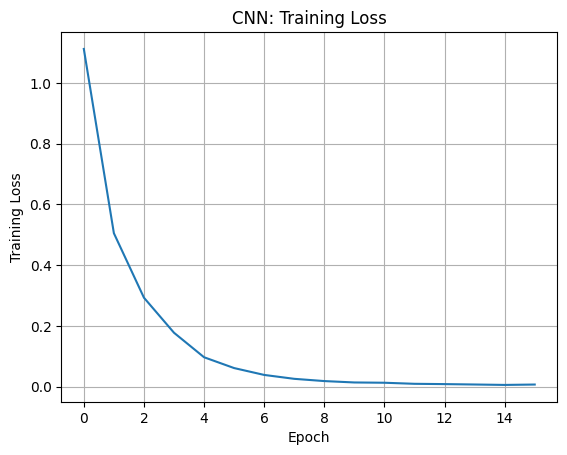

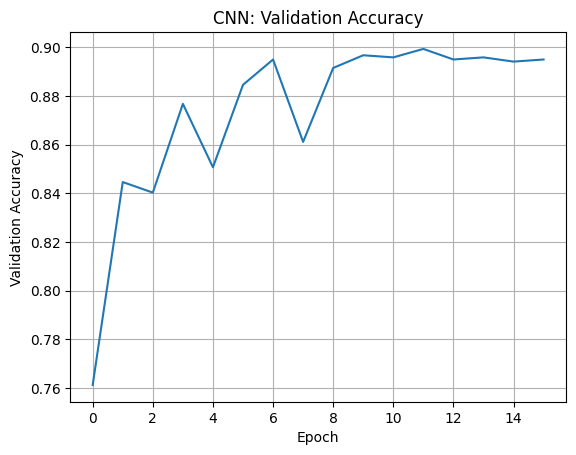

In [13]:
# -----------------------
# Curves: Training Loss & Validation Accuracy
# -----------------------
plt.figure()
plt.plot(history["train_loss"])
plt.xlabel("Epoch"); plt.ylabel("Training Loss"); plt.title("CNN: Training Loss"); plt.grid(True)

plt.figure()
plt.plot(history["valid_acc"])
plt.xlabel("Epoch"); plt.ylabel("Validation Accuracy"); plt.title("CNN: Validation Accuracy"); plt.grid(True)
plt.show()

In [14]:
# -----------------------
# Test accuracy
# -----------------------
_, test_acc = run_epoch(model, test_iter, optimizer=None)
print(f"\n[CNN] Test Accuracy: {test_acc:.4f}")

# -----------------------
# Topic-wise accuracy on TEST
# -----------------------
topic_total = defaultdict(int)
topic_correct = defaultdict(int)

model.eval()
with torch.no_grad():
    for batch in test_iter:
        if isinstance(batch.text, tuple) or isinstance(batch.text, list):
            text, text_lengths = batch.text
        else:
            text, text_lengths = batch.text, None
        y = batch.label
        logits = model(text, text_lengths)
        preds = logits.argmax(1)

        for yi, pi in zip(y.tolist(), preds.tolist()):
            topic = LABEL.vocab.itos[yi]
            topic_total[topic] += 1
            if yi == pi:
                topic_correct[topic] += 1

print("\n[CNN] Topic-wise accuracy (TEST):")
for topic in LABEL.vocab.itos:
    tot = topic_total.get(topic, 0)
    cor = topic_correct.get(topic, 0)
    acc = (cor / tot) if tot > 0 else float("nan")
    print(f"  {topic:>8}: n={tot:3d} | correct={cor:3d} | acc={acc:.3f}")


[CNN] Test Accuracy: 0.9090

[CNN] Topic-wise accuracy (TEST):
       HUM: n= 65 | correct= 64 | acc=0.985
      ENTY: n= 94 | correct= 69 | acc=0.734
      DESC: n=138 | correct=137 | acc=0.993
       NUM: n=113 | correct=103 | acc=0.912
       LOC: n= 81 | correct= 75 | acc=0.926
      ABBR: n=  9 | correct=  7 | acc=0.778
